In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Flatten, MaxPooling1D, Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# from tensorflow import keras 

epochs = 100
dotrain = True
dotest = True
batch_size = 32

In [2]:
Y = pd.DataFrame()


prefix = '/home/gomes/Dropbox/gabriel/work/teaching/mine/emeritus/week23_NN_II/code/traffic/2018/flow_station_1209204_2018_'
for i in range(1,12):
    filename = '{}{:02d}'.format(prefix,i)
    with open(filename,'rb') as f:
        X = pickle.load(f)
        X.set_index(pd.to_datetime(X['Timestamp']),inplace=True)
        X.drop(columns=['Timestamp'],inplace=True)
        Y = Y.append(X)
        
prefix = '/home/gomes/Dropbox/gabriel/work/teaching/mine/emeritus/week23_NN_II/code/traffic/2019/flow_station_1209204_2019_'
for i in range(1,12):
    filename = '{}{:02d}'.format(prefix,i)
    with open(filename,'rb') as f:
        X = pickle.load(f)
        X.set_index(pd.to_datetime(X['Timestamp']),inplace=True)
        X.drop(columns=['Timestamp'],inplace=True)
        Y = Y.append(X)

In [3]:
raw_data = Y['Total Flow'].values
raw_data = MinMaxScaler(feature_range=(0, 1)).fit_transform(raw_data.reshape(-1, 1))

In [4]:
num_train_samples = int(0.8 * len(raw_data))
print("num_train_samples:", num_train_samples)

num_train_samples: 11184


In [5]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [6]:
sequence_length = 24
trainX, trainY = create_dataset(raw_data[:num_train_samples], sequence_length)
testX, testY = create_dataset(raw_data[num_train_samples:], sequence_length)

In [7]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# DENSE

In [8]:
model_dense = Sequential()
model_dense.add(Flatten())
model_dense.add(Dense(16, activation="relu"))
model_dense.add(Dense(1))

model_dense.compile(loss="mse", metrics=["mae"], optimizer="adam")

history_dense = model_dense.fit(trainX, trainY, 
                              epochs=epochs, 
                              batch_size=batch_size,
                              validation_data = (testX, testY),
                              verbose=0)

2021-11-26 22:36:18.651739: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-26 22:36:18.714508: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-26 22:36:18.733773: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1800000000 Hz


# Conv1D

In [9]:
model_1Dconv = Sequential()
model_1Dconv.add(Conv1D(16, 1,input_shape=(1,sequence_length)))
model_1Dconv.add(Dense(1))

model_1Dconv.compile(loss='mse', metrics=["mae"], optimizer='adam')

history_1Dconv = model_1Dconv.fit(trainX, trainY, 
                                  epochs=epochs, 
                                  batch_size=batch_size, 
                                  validation_data = (testX, testY),
                                  verbose=0)

# SimpRNN

In [10]:
model_simprnn = Sequential()
model_simprnn.add(SimpleRNN(10, return_sequences=False,input_shape=(1,sequence_length)))             
model_simprnn.add(Dense(1))

model_simprnn.compile(loss="mse", metrics=["mae"], optimizer="adam")

history_simprnn = model_simprnn.fit(trainX, trainY, 
                                  epochs=epochs, 
                                  batch_size=batch_size, 
                                  validation_data = (testX, testY),
                                  verbose=0)

# LSTM

In [11]:
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(1, sequence_length)))
model_lstm.add(Dense(1))

model_lstm.compile(loss='mse', metrics=["mae"], optimizer='adam')

history_lstm = model_lstm.fit(trainX, trainY, 
                         epochs=epochs, 
                         batch_size=batch_size, 
                         validation_data = (testX, testY),
                         verbose=0)

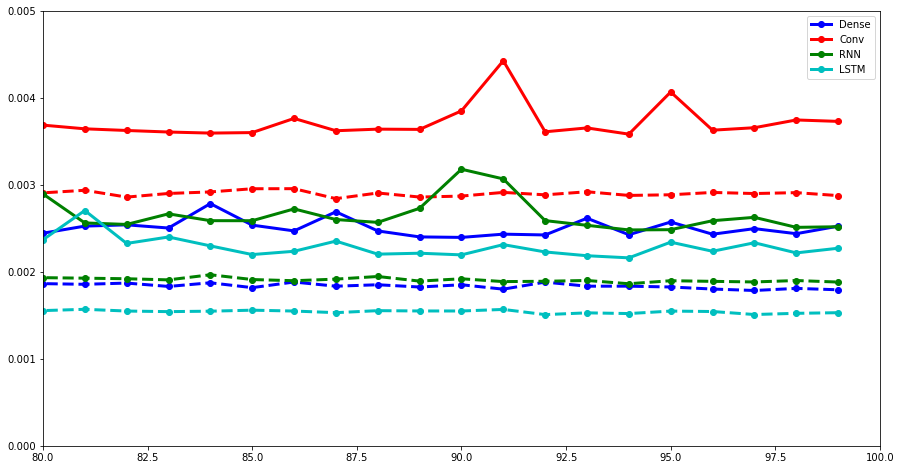

In [12]:
e = range(epochs)

plt.figure(figsize=(15,8))
plt.plot(e,history_dense.history['loss'], 'bo--', linewidth=3)
plt.plot(e,history_dense.history['val_loss'], 'bo-', linewidth=3,label='Dense')
plt.plot(e,history_1Dconv.history['loss'], 'ro--', linewidth=3)
plt.plot(e,history_1Dconv.history['val_loss'], 'ro-', linewidth=3,label='Conv')
plt.plot(e,history_simprnn.history['loss'], 'go--', linewidth=3)
plt.plot(e,history_simprnn.history['val_loss'], 'go-', linewidth=3,label='RNN')
plt.plot(e,history_lstm.history['loss'], 'co--', linewidth=3)
plt.plot(e,history_lstm.history['val_loss'], 'co-', linewidth=3, label='LSTM')
plt.xlim(80,100)
plt.ylim(0,0.005)
plt.legend()